# Forward prediction of Hindi sentiment(s) in CrowdTangle dataset along with translation

## Installs and imports

In [20]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f3ebdb8a54bb06bbb513c98112f2d0b248526e0bba7d87608a1510891c62ae2a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [13]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import MarianTokenizer, MarianMTModel

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import torch

## Global parameters

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_length = 312

BATCH_SIZE = 32

## Load the `CrowdTangle` dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv (
    '/content/drive/My Drive/The-London-Story/CrowdTangle-TLS-workspace/2022-07-11-16-34-58-CEST-Historical-Report-2016-12-31--2022-07-11.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=';', 
    error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.shape

(604703, 40)

Because the size of the dataset is too large, let's choose N entries from the dataframe

In [6]:
#df = df.head(500)
df = df.sample(n = 500) # randomly select 500 entries

In [7]:
df.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

## Data preprocessing

Replace NaN values in particular columns with empty string

In [8]:
df.message = df.message.fillna('')
#df.description = df.description.fillna('')
#df.imageText = df.imageText.fillna('')

Extract particular columns and convert into lists

In [9]:
message_list = df ['message'].tolist()
#imageText_list = df ['imageText'].tolist()

print ("Total number of entries in the dataset:", len(message_list))

Total number of entries in the dataset: 500


## Load the translation model and the tokenizer

Define model parameters

In [ ]:
src = "hi"  # source language
trg = "en"  # target language

tr_model_name = f"Helsinki-NLP/opus-mt-{src}-{trg}"

Load the translation model

In [18]:
tr_model = MarianMTModel.from_pretrained(tr_model_name)
tr_model= tr_model.to(device)

Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

Load the tokenizer of the translation model

In [21]:
tr_tokenizer = MarianTokenizer.from_pretrained(tr_model_name)

## Define the translation function

In [30]:
def translate_hi_to_en (TEXT):
  translated = tr_model.generate (**tr_tokenizer
                                  (TEXT, 
                                   truncation=True, 
                                   padding=True, 
                                   max_length=max_length, 
                                   return_tensors="pt"
                                   ).to(device))
  
  return tr_tokenizer.batch_decode (translated, skip_special_tokens=True)[0]

In [33]:
def translate_list (input_list):
  translated_list = []

  for i in range (len (input_list)):
    if i % 100 == 0:
      print('Example', i+1,' of ', len (input_list))

    if (input_list[i] != ''):
      translated_text = translate_hi_to_en (input_list[i])
    else:
       translated_text = ''

    translated_list.append (translated_text)

  return translated_list

## Translate the dataset and append to the dataframe

In [34]:
message_translated = translate_list (message_list)

Example 1  of  500


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1232: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Example 101  of  500
Example 201  of  500
Example 301  of  500
Example 401  of  500


In [35]:
df ['message.translated'] = message_translated

In [36]:
df.head()

,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,expandedLinks.original,expandedLinks.expanded,imageText,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,message.translated
263518,पुष्पेंद्र कुलश्रेष्ठ फैंस क्लब,Pushpendrarss2,113214903796196,COMMUNITY,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2020-07-13 06:39:03,57057.0,89872.0,2021-08-06 17:37:23 CEST,...,https://khabarbharattak.com/bjp-leader-talked-...,NaN,NaN,दिल्ली पुलिस ने केजरीवाल के साथ किया बड़ा कांड...,BJP leader talked about changing the uniform o...,NaN,NaN,NaN,-1.75,Delhi police arrested the illegal gang of cons...
225363,Ayodhya Junction,TheSanatanTales,104677788010605,SOCIETY_SITE,IN,Ayodhya Junction : The Hub of Positive Vibes,2020-07-29 20:04:09,100737.0,100687.0,2021-09-23 06:30:46 CEST,...,https://appearnews.com/interview-question-hipp...,NaN,NaN,Interview Question: किस जानवर का दूध गुलाबी रं...,आज के समय में हर कोई चाहता है कि उसको कोई अच्छ...,NaN,NaN,NaN,-39,Interview: Which animal is the milk of pink?
186320,पुष्पेंद्र कुलश्रेष्ठ फैंस क्लब,Pushpendrarss2,113214903796196,COMMUNITY,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2020-07-13 06:39:03,58902.0,91701.0,2021-10-28 18:04:45 CEST,...,https://sachkhabar.co.in/indian-army-preparing...,NaN,NaN,PoK को वापस लेने की तैयारी कर रही है भारतीय से...,जैसा कि जम्मू कश्मीर अनुच्छेद 370 को बिल्कुल ह...,NaN,NaN,NaN,8.21,Preparing to take the POK back to the Indian a...
513555,Ojasvi Akhand Bharat,OjasviAkhandBharat,574954365905490,ORG_GENERAL,NaN,OjasviBharat,2013-09-30 06:18:23,NaN,NaN,2019-10-25 06:14:08 CEST,...,https://www.facebook.com/HariomHealth22/photos...,NaN,NaN,Hariom Health,प्याज के 141 चमत्कारिक औषधीय प्रयोग\n=========...,NaN,NaN,NaN,-0.89,
11585,IndiaVirals,udaanupdates,234540670328769,NEWS_SITE,IN,News & media website,2017-01-08 06:52:04,546524.0,542506.0,2022-06-19 07:12:25 CEST,...,https://hindimoviekhabar.com/when-mms-of-these...,NaN,NaN,जब बॉलीवुड की इन 10 फेमस अभिनेत्रियों के MMS ह...,बॉलीवुड इंडस्ट्री और विवाद का एक दूसरे से काफी...,NaN,NaN,NaN,-4,"When these 10-MS of Bhutwood's 10-MS leaks, pe..."


## Load the sentiment analysis model and the tokenizer


Define parameters

In [44]:
n_labels = 3

labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

Load the model and the tokenizer

In [38]:
model_config = AutoConfig.from_pretrained(MODEL, num_labels=n_labels)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=MODEL, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=MODEL, config=model_config)

model.to(device)
model.eval()

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## Define the forward prediction functions

In [45]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  encoded_input.to(device)
  
  output = model(**encoded_input)
  scores = output[0].detach().cpu().numpy()
  scores = softmax(scores, axis=-1)
  
  return scores

In [46]:
def sentiment_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  sentiment_pred = []

  for idx, batch in enumerate(dl):
    print('Batch ',idx+1,' of ', len(dl))

    if (batch != ''):
      scores = forward(batch)
      preds = np.argmax(scores, axis=-1)
    else:
      preds = 1
    sentiment_pred.extend(preds)
  
  return sentiment_pred

## Run sentiment prediction task on the dataset(s) and save the results

Sentiment prediction over original messages

In [47]:
message_sentiment_score = sentiment_pred_score (message_list)

Batch  1  of  16
Batch  2  of  16
Batch  3  of  16
Batch  4  of  16
Batch  5  of  16
Batch  6  of  16
Batch  7  of  16
Batch  8  of  16
Batch  9  of  16
Batch  10  of  16
Batch  11  of  16
Batch  12  of  16
Batch  13  of  16
Batch  14  of  16
Batch  15  of  16
Batch  16  of  16


Sentiment prediction over translated messages

In [59]:
translated_message_sentiment_score = sentiment_pred_score (message_translated)

Batch  1  of  16
Batch  2  of  16
Batch  3  of  16
Batch  4  of  16
Batch  5  of  16
Batch  6  of  16
Batch  7  of  16
Batch  8  of  16
Batch  9  of  16
Batch  10  of  16
Batch  11  of  16
Batch  12  of  16
Batch  13  of  16
Batch  14  of  16
Batch  15  of  16
Batch  16  of  16


Append the prediction scores to the original pandas dataframe

In [60]:
df ['messageSentiment.score'] = message_sentiment_score
df ['translatedMessageSentiment.score'] = translated_message_sentiment_score

In [61]:
df.head()

,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,imageText,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,message.translated,messageSentiment.score,translatedMessageSentiment.score
263518,पुष्पेंद्र कुलश्रेष्ठ फैंस क्लब,Pushpendrarss2,113214903796196,COMMUNITY,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2020-07-13 06:39:03,57057.0,89872.0,2021-08-06 17:37:23 CEST,...,NaN,दिल्ली पुलिस ने केजरीवाल के साथ किया बड़ा कांड...,BJP leader talked about changing the uniform o...,NaN,NaN,NaN,-1.75,Delhi police arrested the illegal gang of cons...,0,0
225363,Ayodhya Junction,TheSanatanTales,104677788010605,SOCIETY_SITE,IN,Ayodhya Junction : The Hub of Positive Vibes,2020-07-29 20:04:09,100737.0,100687.0,2021-09-23 06:30:46 CEST,...,NaN,Interview Question: किस जानवर का दूध गुलाबी रं...,आज के समय में हर कोई चाहता है कि उसको कोई अच्छ...,NaN,NaN,NaN,-39,Interview: Which animal is the milk of pink?,1,1
186320,पुष्पेंद्र कुलश्रेष्ठ फैंस क्लब,Pushpendrarss2,113214903796196,COMMUNITY,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2020-07-13 06:39:03,58902.0,91701.0,2021-10-28 18:04:45 CEST,...,NaN,PoK को वापस लेने की तैयारी कर रही है भारतीय से...,जैसा कि जम्मू कश्मीर अनुच्छेद 370 को बिल्कुल ह...,NaN,NaN,NaN,8.21,Preparing to take the POK back to the Indian a...,1,1
513555,Ojasvi Akhand Bharat,OjasviAkhandBharat,574954365905490,ORG_GENERAL,NaN,OjasviBharat,2013-09-30 06:18:23,NaN,NaN,2019-10-25 06:14:08 CEST,...,NaN,Hariom Health,प्याज के 141 चमत्कारिक औषधीय प्रयोग\n=========...,NaN,NaN,NaN,-0.89,,0,0
11585,IndiaVirals,udaanupdates,234540670328769,NEWS_SITE,IN,News & media website,2017-01-08 06:52:04,546524.0,542506.0,2022-06-19 07:12:25 CEST,...,NaN,जब बॉलीवुड की इन 10 फेमस अभिनेत्रियों के MMS ह...,बॉलीवुड इंडस्ट्री और विवाद का एक दूसरे से काफी...,NaN,NaN,NaN,-4,"When these 10-MS of Bhutwood's 10-MS leaks, pe...",1,0


Save the dataframe (along with the results)

In [62]:
df.to_csv('/content/drive/MyDrive/CT_sentiment_prediction_with_translated.csv', index=False)

## Visualization of the results

Histograms of the predicted scores

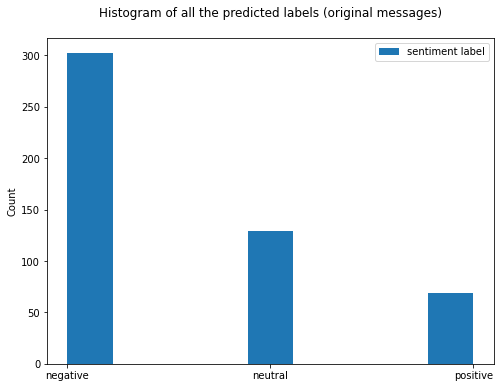

In [65]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots (figsize=(8, 6))
plt.title ('Histogram of all the predicted labels (original messages)\n')
plt.hist (df ['messageSentiment.score'], bins, label=['sentiment label'] )
ax.set_ylabel ('Count')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.legend (loc='upper right')
plt.show ()

Bar plot of top actors

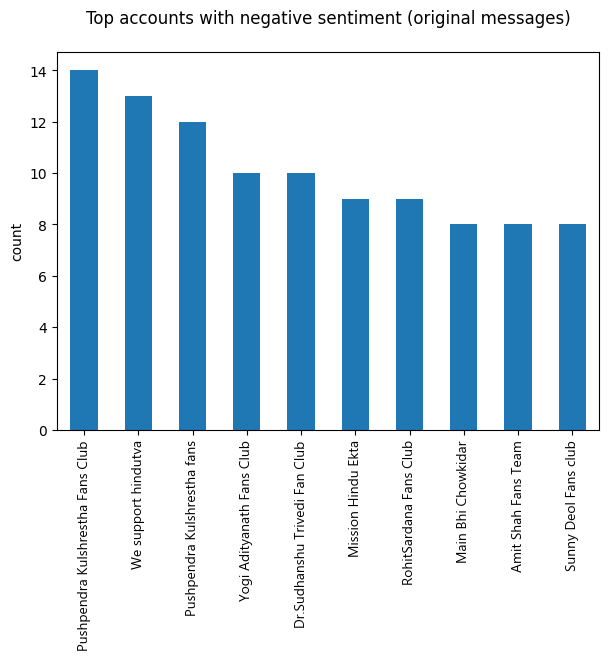

In [63]:
plt.figure(figsize=(7,5),dpi=100)

negative_sentiment = df [df['messageSentiment.score'] == 0]
negative_sentiment ['account.name'].value_counts()[:10].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/The-London-Story/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)

plt.title('Top accounts with negative sentiment (original messages)\n')
plt.ylabel('count')

plt.show()

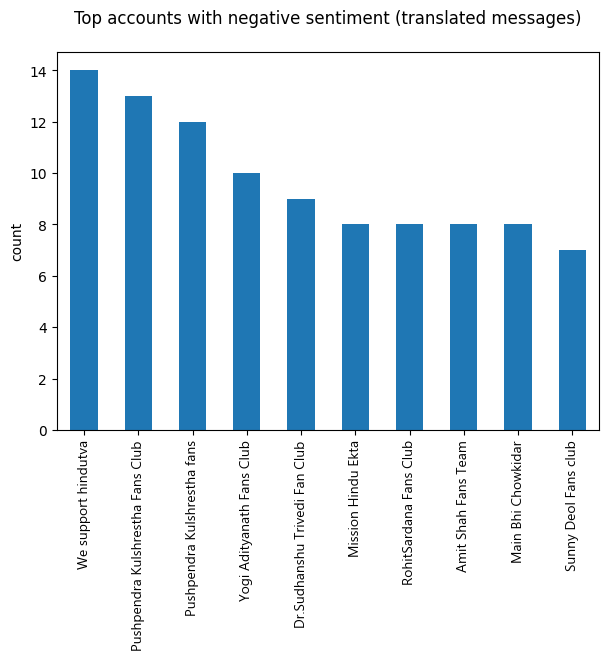

In [64]:
plt.figure(figsize=(7,5),dpi=100)

negative_sentiment = df [df['translatedMessageSentiment.score'] == 0]
negative_sentiment ['account.name'].value_counts()[:10].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/The-London-Story/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)

plt.title('Top accounts with negative sentiment (translated messages)\n')
plt.ylabel('count')

plt.show()

Inspect those entries when the sentiment predictions scores on original and translated messages don't match

In [69]:
df ['sentiment.agreement'] = np.where((df['messageSentiment.score'] == df['translatedMessageSentiment.score']), 'Y', 'N')

In [74]:
disagree_df = df [df['sentiment.agreement'] == 'N']

In [75]:
print ("Total number of entries where the scores disagree:", len(disagree_df))
disagree_df.head()

Total number of entries where the scores disagree: 127


,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,message.translated,messageSentiment.score,translatedMessageSentiment.score,sentiment.agreement
11585,IndiaVirals,udaanupdates,234540670328769,NEWS_SITE,IN,News & media website,2017-01-08 06:52:04,546524.0,542506.0,2022-06-19 07:12:25 CEST,...,जब बॉलीवुड की इन 10 फेमस अभिनेत्रियों के MMS ह...,बॉलीवुड इंडस्ट्री और विवाद का एक दूसरे से काफी...,NaN,NaN,NaN,-4,"When these 10-MS of Bhutwood's 10-MS leaks, pe...",1,0,N
581538,IndiaVirals,udaanupdates,234540670328769,NEWS_SITE,IN,News & media website,2017-01-08 06:52:04,203237.0,204308.0,2018-04-04 07:27:29 CEST,...,NaN,NaN,NaN,NaN,NaN,-14.9,"If this post is liked by you, check it out, co...",2,1,N
259211,We Support Pushpendra Kulshrestha,NaN,100063803915990,PERSONAL_BLOG,NaN,Pushpendra Kulshrestha,2020-12-31 08:26:51,NaN,NaN,2021-08-13 15:49:34 CEST,...,Photos from We Support Pushpendra Kulshrestha'...,NaN,NaN,NaN,NaN,1.96,The new picture of kamir ),2,1,N
524631,अभिषेक सिंह,kattarhindurajput111,100053001286794,PERSON,IN,श्री राम भक्त,2018-04-19 07:58:41,NaN,NaN,2019-08-04 16:10:04 CEST,...,NaN,NaN,NaN,NaN,NaN,-22.4,Hap,2,1,N
315950,IndiaVirals,udaanupdates,234540670328769,NEWS_SITE,IN,News & media website,2017-01-08 06:52:04,529690.0,529568.0,2021-05-31 09:32:46 CEST,...,सेंट्रल विस्टा प्रोजेक्ट को रुकवाने की याचिका ...,central vista project: सेंट्रल विस्टा प्रोजेक्...,NaN,NaN,NaN,6,The Court is also organized.,0,1,N
